In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer   # 数据预处理 - 填补缺省值
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import label_binarize

from sklearn import metrics

In [2]:
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

##### 1、数据加载

In [3]:
names = [u'Age', u'Number of sexual partners', u'First sexual intercourse',
       u'Num of pregnancies', u'Smokes', u'Smokes (years)',
       u'Smokes (packs/year)', u'Hormonal Contraceptives',
       u'Hormonal Contraceptives (years)', u'IUD', u'IUD (years)', u'STDs',
       u'STDs (number)', u'STDs:condylomatosis',
       u'STDs:cervical condylomatosis', u'STDs:vaginal condylomatosis',
       u'STDs:vulvo-perineal condylomatosis', u'STDs:syphilis',
       u'STDs:pelvic inflammatory disease', u'STDs:genital herpes',
       u'STDs:molluscum contagiosum', u'STDs:AIDS', u'STDs:HIV',
       u'STDs:Hepatitis B', u'STDs:HPV', u'STDs: Number of diagnosis',
       u'STDs: Time since first diagnosis', u'STDs: Time since last diagnosis',
       u'Dx:Cancer', u'Dx:CIN', u'Dx:HPV', u'Dx', 
       u'Hinselmann', u'Schiller',u'Citology', u'Biopsy']

path = "datas/risk_factors_cervical_cancer.csv"
data = pd.read_csv(path)
data.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


##### 2、数据预处理 - 缺省值替换 + 数据分割

In [5]:
X = data[names[0:-4]]   # data自带columns，所以用names来划分
Y = data[names[-4:]]   # 随机森林可以处理多个目标变量的情况

—— sklearn.preprocessing.Imputer(missing_values=’NaN’, strategy=’mean’, axis , copy) 填补缺失值   ★

    -》missing_values：待替换值，可以为整数或NaN
    -》strategy：替换策略
    ①若为mean时，用特征列的均值替换，默认为mean
    ②若为median时，用特征列的中位数替换
    ③若为most_frequent时，用特征列的众数替换

    -》copy：默认为True，代表不在原数据集上修改。设置为False时，对原数据进行修改

In [6]:
X = X.replace("?", np.NAN)   # 空值的处理，将 ？ 替换为 NaN

imputer = Imputer(missing_values="NaN")   # 对缺省值以列进行数据填充
X = imputer.fit_transform(X)   # 缺省处理

x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print ("训练样本数量:%d,特征属性数目:%d,目标属性数目:%d" % (x_train.shape[0],x_train.shape[1],y_train.shape[1]))
print ("测试样本数量:%d" % x_test.shape[0])

训练样本数量:686,特征属性数目:32,目标属性数目:4
测试样本数量:172


C:\4_IT\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


##### 3、数据预处理 - 标准化训练

In [117]:
ss = MinMaxScaler()
x_train = ss.fit_transform(x_train, y_train)
x_test = ss.transform(x_test)
x_train.shape

(686, 32)

##### 3.1降维

In [12]:
pca = PCA(n_components=2)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

##### 4、模型构建 + 训练 + 评估 + 预测
—— RandomForestClassifier() 随机森林分类模型

    -》n_estimators：最大决策树数量，即最大迭代次数。默认100
    -》max_features：允许单个决策树使用特征的最大数量。

    Auto：简单地选取所有特征，每颗树都可以利用他们
    sqrt：每颗子树可以利用总特征数的平方根个。例如，如果变量（特征）的总数是100，所以每颗子树只能取其中的10个。
    小数：若等于0.2：此选项允许每个随机森林的子树可以利用变量（特征）数的20％
    
    -》min_sample_leaf：最小样本叶片大小。 较小的叶子使模型更容易捕捉训练数据中的噪声，一般来说，可将最小叶子节点数目设置为大于50。

In [16]:
forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=1, random_state=0)
forest.fit(x_train, y_train)
score = forest.score(x_test, y_test)
print ("准确率:%.2f%%" % (score * 100))

y_predict_class = forest.predict_proba(x_test)   # 概率矩阵，注意Y有4列
y_predict_class[0][:5]   # 可以通过 .value_counts() 来确定标签类型，但是没必要

准确率:89.53%


array([[0.95487409, 0.04512591],
       [0.81246186, 0.18753814],
       [0.95453628, 0.04546372],
       [0.95010091, 0.04989909],
       [0.95407713, 0.04592287]])

##### ROC曲线

In [28]:
y1_test_class = label_binarize(y_test[names[-4]],classes=(0,1,2))  # 虽然classes=(0,1,2)，但是实际值只有0和1，最后一列是没有用的，要删去
y2_test_calss = label_binarize(y_test[names[-3]],classes=(0,1,2))
y3_test_calss = label_binarize(y_test[names[-2]],classes=(0,1,2))
y4_test_calss = label_binarize(y_test[names[-1]],classes=(0,1,2))

y1_test_class[0:5]

0    170
1      2
Name: Hinselmann, dtype: int64


In [18]:
forest_fpr1, forest_tpr1, threshold1 = metrics.roc_curve(y1_test_class[:,0:-1].ravel(), y_predict_class[0].ravel())
forest_fpr2, forest_tpr2, threshold2 = metrics.roc_curve(y2_test_class[:,0:-1].ravel(), y_predict_class[1].ravel())
forest_fpr3, forest_tpr3, threshold3 = metrics.roc_curve(y3_test_class[:,0:-1].ravel(), y_predict_class[2].ravel())
forest_fpr4, forest_tpr4, threshold4 = metrics.roc_curve(y4_test_class[:,0:-1].ravel(), y_predict_class[3].ravel())

0    170
1      2
Name: Hinselmann, dtype: int64
4


(172, 2)

In [121]:
auc1 = metrics.auc(forest_fpr1, forest_tpr1)
auc2 = metrics.auc(forest_fpr2, forest_tpr2)
auc3 = metrics.auc(forest_fpr3, forest_tpr3)
auc4 = metrics.auc(forest_fpr4, forest_tpr4)

print ("y1 Hinselmann目标属性AUC值：", auc1)
print ("y2 Schiller目标属性AUC值：", auc2)
print ("y3 Citology目标属性AUC值：", auc3)
print ("y4 Biopsy目标属性AUC值：", auc4)

y1 Hinselmann目标属性AUC值： 0.9901974040021634
y2 Schiller目标属性AUC值： 0.9559221200648998
y3 Citology目标属性AUC值： 0.9637979989183343
y4 Biopsy目标属性AUC值： 0.9568685776095187


##### 5、画图

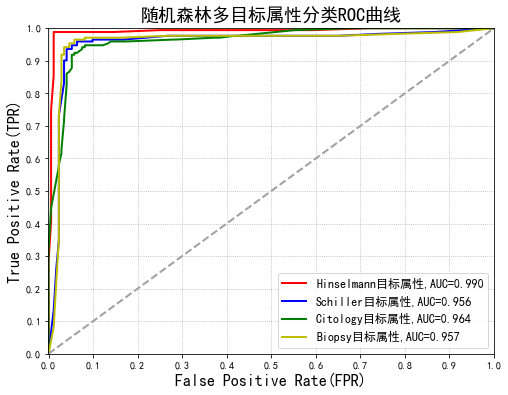

In [122]:
plt.figure(figsize=(8, 6), facecolor='w')

plt.plot(forest_fpr1,forest_tpr1,c='r',lw=2,label='Hinselmann目标属性,AUC=%.3f' % auc1)
plt.plot(forest_fpr2,forest_tpr2,c='b',lw=2,label='Schiller目标属性,AUC=%.3f' % auc2)
plt.plot(forest_fpr3,forest_tpr3,c='g',lw=2,label='Citology目标属性,AUC=%.3f' % auc3)
plt.plot(forest_fpr4,forest_tpr4,c='y',lw=2,label='Biopsy目标属性,AUC=%.3f' % auc4)
plt.plot((0,1),(0,1),c='#a0a0a0',lw=2,ls='--')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)

plt.xlim(-0.001, 1.001)
plt.ylim(-0.001, 1.001)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate(FPR)', fontsize=16)
plt.ylabel('True Positive Rate(TPR)', fontsize=16)
plt.grid(b=True, ls=':')
plt.title(u'随机森林多目标属性分类ROC曲线', fontsize=18)
plt.show()

# 参数优化

##### 比较不同 树数目、树最大深度 的随机森林错误率
随机森林和Boosting一般都用错误率来评估

In [31]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(X, Y, test_size=0.5, random_state=0)
print ("训练样本数量%d，测试样本数量:%d" % (x_train2.shape[0], x_test2.shape[0]))

训练样本数量429，测试样本数量:429


In [35]:
estimators = [1,50,100,500]   # 子树的数量，也是迭代数量
depth = [1,2,3,7,15]   # 字数深度
incorr_list = []   # 存储每次迭代的树的错误率

for m in estimators:   # m数量的子树
    es_list = []
    for d in depth:
        model = RandomForestClassifier(n_estimators=m, criterion='gini', max_depth=d, max_features = None, random_state=0)
        model.fit(x_train2, y_train2)
        score = model.score(x_test2, y_test2)
        
        es_list.append(1-score)
        print ("决策树个数：%d\t 最大深度：%d\t 错误率：%.2f%%" % (i, d, (1-score) * 100))
    incorr_list.append(es_list)

np.array(incorr_list).shape

决策树个数：0	 最大深度：1	 错误率：13.52%
决策树个数：0	 最大深度：2	 错误率：13.05%
决策树个数：0	 最大深度：3	 错误率：15.38%
决策树个数：0	 最大深度：7	 错误率：17.25%
决策树个数：0	 最大深度：15	 错误率：21.91%
决策树个数：0	 最大深度：1	 错误率：13.29%
决策树个数：0	 最大深度：2	 错误率：13.52%
决策树个数：0	 最大深度：3	 错误率：13.52%
决策树个数：0	 最大深度：7	 错误率：13.75%
决策树个数：0	 最大深度：15	 错误率：15.62%
决策树个数：0	 最大深度：1	 错误率：13.05%
决策树个数：0	 最大深度：2	 错误率：13.75%
决策树个数：0	 最大深度：3	 错误率：13.52%
决策树个数：0	 最大深度：7	 错误率：13.75%
决策树个数：0	 最大深度：15	 错误率：14.92%
决策树个数：0	 最大深度：1	 错误率：13.52%
决策树个数：0	 最大深度：2	 错误率：13.52%
决策树个数：0	 最大深度：3	 错误率：13.52%
决策树个数：0	 最大深度：7	 错误率：13.75%
决策树个数：0	 最大深度：15	 错误率：15.15%


(4, 5)

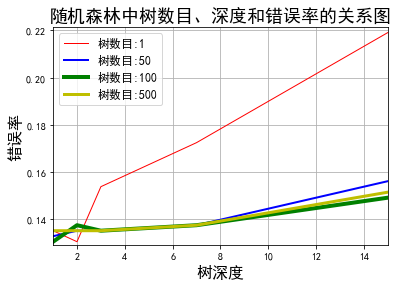

In [40]:
plt.figure(facecolor='w')

i = 0   # 控制线颜色和线粗
colors = ['r','b','g','y']
lw = [1,2,4,3]

max_err,min_err = 0,1

for m,n in zip(estimators,incorr_list):
    plt.plot(depth, n, c=colors[i], lw=lw[i], label='树数目:%d' % m)
    max_err = max((max(n),max_err))
    min_err = min((min(n),min_err))
    i += 1

plt.xlim(min(depth),max(depth))
plt.ylim(min_err * 0.99, max_err * 1.01)
plt.xlabel('树深度', fontsize=16)
plt.ylabel('错误率', fontsize=16)
plt.legend(loc='upper left', fancybox=True, framealpha=0.8, fontsize=12)
plt.grid(True)
plt.title('随机森林中树数目、深度和错误率的关系图', fontsize=18)
plt.show()

### 随机森林图

In [94]:
from sklearn import tree
from IPython.display import Image  
import pydotplus
k = 0
for clf in forest.estimators_:
    dot_data = tree.export_graphviz(clf, out_file=None,  
                         filled=True, rounded=True,  
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    # graph.write_pdf("foress_tree_%d.pdf" % k)
    if k == 0:
        # 只输出一个，其它的不输出
        graph.write_png("foress_tree_0.png")
    k += 1